## Transformada de Fourier

In [1]:
import numpy as np
import cv2 
from matplotlib import pyplot as plt
img1 = cv2.imread('marte.jpg', 0)
img2 = cv2.imread('gradient_noise.png', 0)
img3 = cv2.imread('board.jpg', 0)

#### Aqui vamos ver alguns exemplos de como implementar manualmente a transformada. Ao final, será apresentado o algoritmo disponível em biblioteca.

In [2]:
# implementing a 2D version of the DFT
def DFT2D(f):
    # create empty array of complex coefficients
    F = np.zeros(f.shape, dtype=np.complex64)
    n,m = f.shape[0:2]
    
    # creating indices for x, to compute multiplication using numpy (f*exp)
    x = np.arange(n)
    # for each frequency 'u,v'
    for u in np.arange(n):
        for v in np.arange(m):
            for y in np.arange(m):
                F[u,v] += np.sum(f[:,y] * np.exp( (-1j*2*np.pi) * (((u*x)/n)+((v*y)/m)) ))
    
    return F/np.sqrt(n*m)

In [3]:
# implementing a 2D version of the DFT
def IDFT2D(F):
    # create empty array of complex coefficients
    f = np.zeros(F.shape, dtype=np.int32)
    n,m = F.shape[0:2]
    
    # creating indices for x, to compute multiplication using numpy (f*exp)
    u = np.arange(n)
    # for each frequency 'u,v'
    for x in np.arange(n):
        for y in np.arange(m):
            for v in np.arange(m):
                f[x,y] += np.real(np.sum(F[:,v] * np.exp( (1j*2*np.pi) * (((u*x)/n)+((v*y)/m)) )))
    
    return np.real(f/np.sqrt(n*m))

In [4]:
# extracting subimages with 64x64=4096 pixels
sizes = 64
img1_s = img1
img2_s = img2[0:sizes, 0:sizes]
img3_s = img3[5:sizes+5, 5:sizes+5]

F1s = DFT2D(img1_s)
F2s = DFT2D(img2_s)
F3s = DFT2D(img3_s)

(-0.5, 63.5, 63.5, -0.5)

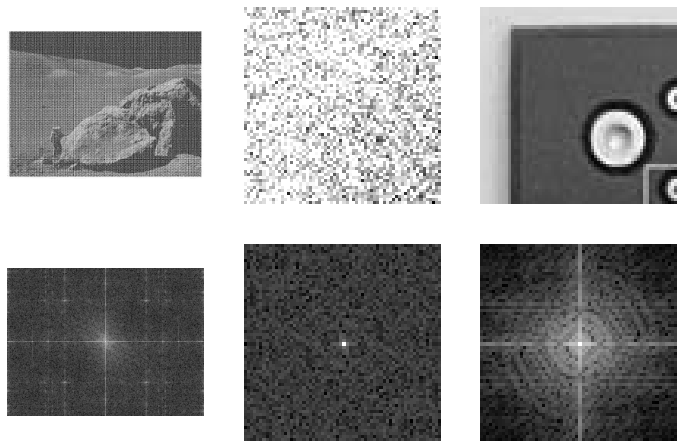

In [5]:
plt.figure(figsize=(12,8)) 
plt.subplot(231)
plt.imshow(img1_s, cmap="gray"); plt.axis('off')
plt.subplot(232)
plt.imshow(img2_s, cmap="gray"); plt.axis('off')
plt.subplot(233)
plt.imshow(img3_s, cmap="gray"); plt.axis('off')

# the log of the magnitudes 
plt.subplot(234)
plt.imshow(np.log(1 + np.fft.fftshift(np.abs(F1s))), cmap="gray")
plt.axis('off')
plt.subplot(235)
plt.imshow(np.log(1 + np.fft.fftshift(np.abs(F2s))), cmap="gray")
plt.axis('off')
plt.subplot(236)
plt.imshow(np.log(1 + np.fft.fftshift(np.abs(F3s))), cmap="gray")
plt.axis('off')

É possível notar os diferentes padrões de frequência que surgem de imagens diferentes.
* o primeiro (mais à esquerda) contém principalmente oscilações horizontais e verticais,
* o segundo (no meio) é apenas ruído, então o espectro é aproximadamente uniforme,
* o último (mais à direita) tem padrões horizontais, verticais, mas também circulares, que aparecem no espectro.


Vamos agora filtrar as frequências nessas imagens para ver os efeitos dos filtros:
* passa alta
* passa baixa
* rejeita banda 


### FFTshift(X) 
Reorganiza uma transformada de Fourier X deslocando o componente de frequência zero para o centro da matriz.

* Se X for um vetor, então fftshift troca as metades esquerda e direita de X.

* Se X for uma matriz, então fftshift troca o primeiro quadrante de X pelo terceiro e o segundo quadrante pelo quarto.

* Se X for uma matriz multidimensional, então fftshift troca semiespaços de X ao longo de cada dimensão.

Depois: 
- Zere o centro de nossa mudança FFT (ou seja, para remover baixas frequências) através de F1p[n2-9:n2+9, m2-9:m2+9] = 0. Esses valores de 9 é o tamanho do raio em torno do ponto central da imagem para o qual zera o deslocamento FFT. Pode modificar.
- Aplique a mudança inversa para colocar o componente DC de volta no canto superior esquerdo (Linha com F1p = np.fft.ifftshift(F1p))
- Aplique o FFT inverso (aplique i1p = IDFT2D(F1p))

In [6]:
n2 = F1s.shape[0]//2
m2 = F1s.shape[1]//2

F1p = np.fft.fftshift(F1s).copy()
F1p[n2-9:n2+9, m2-9:m2+9] = 0 # square high pass filter, removes first frequencies
F1p = np.fft.ifftshift(F1p)
    
F2p = np.fft.fftshift(F2s).copy()
F2p[:n2-9, :] = 0 # square low pass filter, removes higher frequencies
F2p[:, :m2-9] = 0 # square low pass filter, removes higher frequencies
F2p[n2+9:, :] = 0 # square low pass filter, removes higher frequencies
F2p[:, m2+9:] = 0 # square low pass filter, removes higher frequencies
F2p = np.fft.ifftshift(F2p)

F3p = F3s.copy()
F3p[5:-5,5:-5] = 0 # band stop filter
#F3p = np.fft.ifftshift(F3p)

i1p = IDFT2D(F1p)
i2p = IDFT2D(F2p)
i3p = IDFT2D(F3p)

Text(0.5, 1.0, 'original')

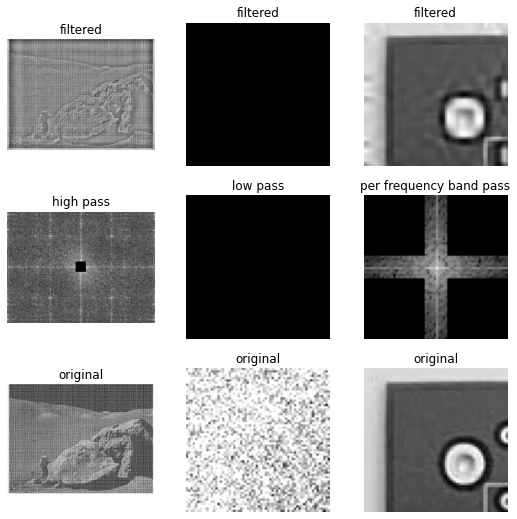

In [7]:
plt.figure(figsize=(9,9)) 
plt.subplot(331)
plt.imshow(i1p, cmap="gray"); plt.axis('off'); plt.title('filtered')
plt.subplot(332)
plt.imshow(i2p, cmap="gray"); plt.axis('off'); plt.title('filtered')
plt.subplot(333)
plt.imshow(i3p, cmap="gray"); plt.axis('off'); plt.title('filtered')

# the log of the magnitudes 
plt.subplot(334)
plt.imshow(np.log(1 + np.fft.fftshift(np.abs(F1p))), cmap="gray")
plt.axis('off'); plt.title('high pass')
plt.subplot(335)
plt.imshow(np.log(1 + np.fft.fftshift(np.abs(F2p))), cmap="gray")
plt.axis('off'); plt.title('low pass')
plt.subplot(336)
plt.imshow(np.log(1 + np.fft.fftshift(np.abs(F3p))), cmap="gray")
plt.axis('off'); plt.title('per frequency band pass')

plt.subplot(337)
plt.imshow(img1_s, cmap="gray"); plt.axis('off'); plt.title('original')
plt.subplot(338)
plt.imshow(img2_s, cmap="gray"); plt.axis('off'); plt.title('original')
plt.subplot(339)
plt.imshow(img3_s, cmap="gray"); plt.axis('off'); plt.title('original')

## No OpenCV 

In [8]:
F1s = cv2.dft(np.float32(img1_s),flags = cv2.DFT_COMPLEX_OUTPUT)
F2s = cv2.dft(np.float32(img2_s),flags = cv2.DFT_COMPLEX_OUTPUT)
F3s = cv2.dft(np.float32(img3_s),flags = cv2.DFT_COMPLEX_OUTPUT)

dft_shift1 = np.fft.fftshift(F1s)
dft_shift2 = np.fft.fftshift(F2s)
dft_shift3 = np.fft.fftshift(F3s)

magnitude_spectrum1 = 20*np.log(cv2.magnitude(dft_shift1[:,:,0],dft_shift1[:,:,1]))
magnitude_spectrum2 = 20*np.log(cv2.magnitude(dft_shift2[:,:,0],dft_shift2[:,:,1]))
magnitude_spectrum3 = 20*np.log(cv2.magnitude(dft_shift3[:,:,0],dft_shift3[:,:,1]))

Text(0.5, 1.0, 'filtered')

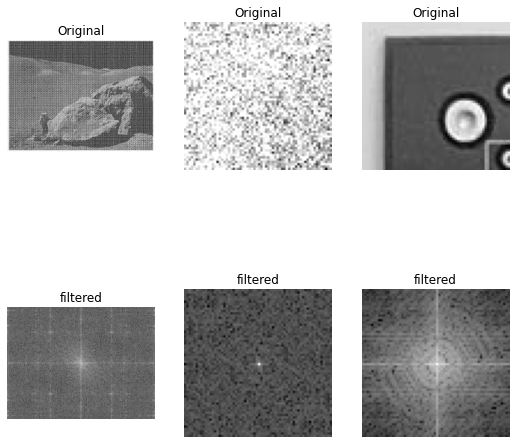

In [9]:
plt.figure(figsize=(9,9)) 
plt.subplot(231)
plt.imshow(img1_s, cmap="gray"); plt.axis('off'); plt.title('Original')
plt.subplot(232)
plt.imshow(img2_s, cmap="gray"); plt.axis('off'); plt.title('Original')
plt.subplot(233)
plt.imshow(img3_s, cmap="gray"); plt.axis('off'); plt.title('Original')
plt.subplot(234)
plt.imshow(magnitude_spectrum1, cmap="gray"); plt.axis('off'); plt.title('filtered')
plt.subplot(235)
plt.imshow(magnitude_spectrum2, cmap="gray"); plt.axis('off'); plt.title('filtered')
plt.subplot(236)
plt.imshow(magnitude_spectrum3, cmap="gray"); plt.axis('off'); plt.title('filtered')

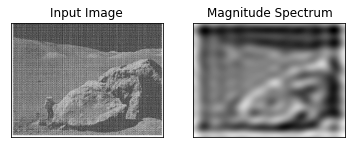

In [10]:
#Aplicando o LFP
rows1 = F1s.shape[0]//2
cols1 = F1s.shape[1]//2


F1p = np.fft.fftshift(F1s).copy()
F1p[:n2-9, :] = 0 # square low pass filter, removes higher frequencies
F1p[:, :m2-9] = 0 # square low pass filter, removes higher frequencies
F1p[n2+9:, :] = 0 # square low pass filter, removes higher frequencies
F1p[:, m2+9:] = 0 # square low pass filter, removes higher frequencies
F1p = np.fft.ifftshift(F1p)

img_back = cv2.idft(F1p)
img_back = cv2.magnitude(img_back[:,:,0],img_back[:,:,1])

plt.subplot(121),plt.imshow(img1_s, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img_back, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])

plt.show()